<a href="https://colab.research.google.com/github/Anshuldogra001/Investo_Assignment/blob/main/Assignment_investo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! pip install yfinance
! pip install pandas_schema
! pip install statsmodels
! pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 133.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 22.0 MB/s eta 0:00:00



STOCK MARKET PREDICTION PIPELINE
Hedge Fund Data Science Internship Project

Analyzing 8 stocks: AAPL, MSFT, GOOGL, AMZN, TSLA, JPM, V, NVDA
Date range: 2022-10-22 to 2025-10-21
TASK 1: DATA ACQUISITION

Fetching data for AAPL...
 Successfully fetched 750 records for AAPL
  Date range: 2022-10-24 to 2025-10-20

Fetching data for MSFT...
 Successfully fetched 750 records for MSFT
  Date range: 2022-10-24 to 2025-10-20

Fetching data for GOOGL...
 Successfully fetched 750 records for GOOGL
  Date range: 2022-10-24 to 2025-10-20

Fetching data for AMZN...
 Successfully fetched 750 records for AMZN
  Date range: 2022-10-24 to 2025-10-20

Fetching data for TSLA...
 Successfully fetched 750 records for TSLA
  Date range: 2022-10-24 to 2025-10-20

Fetching data for JPM...
 Successfully fetched 750 records for JPM
  Date range: 2022-10-24 to 2025-10-20

Fetching data for V...
 Successfully fetched 750 records for V
  Date range: 2022-10-24 to 2025-10-20

Fetching data for NVDA...
 Successfull

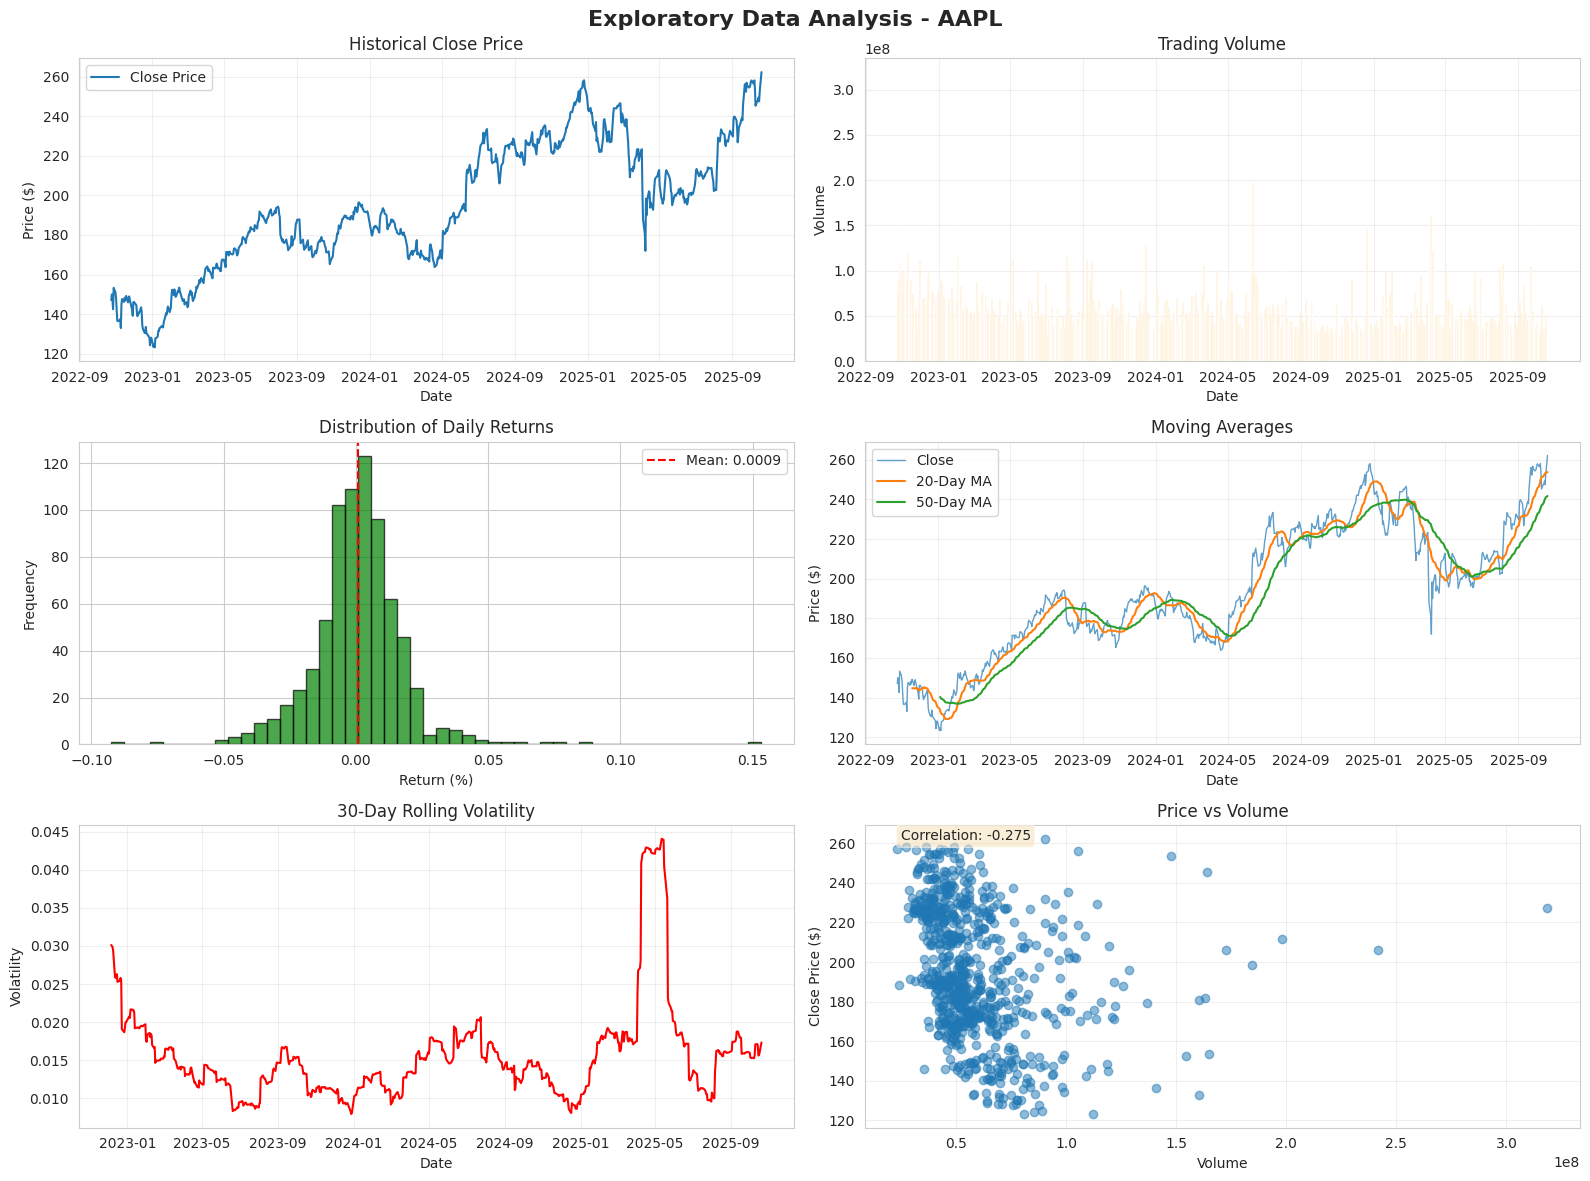

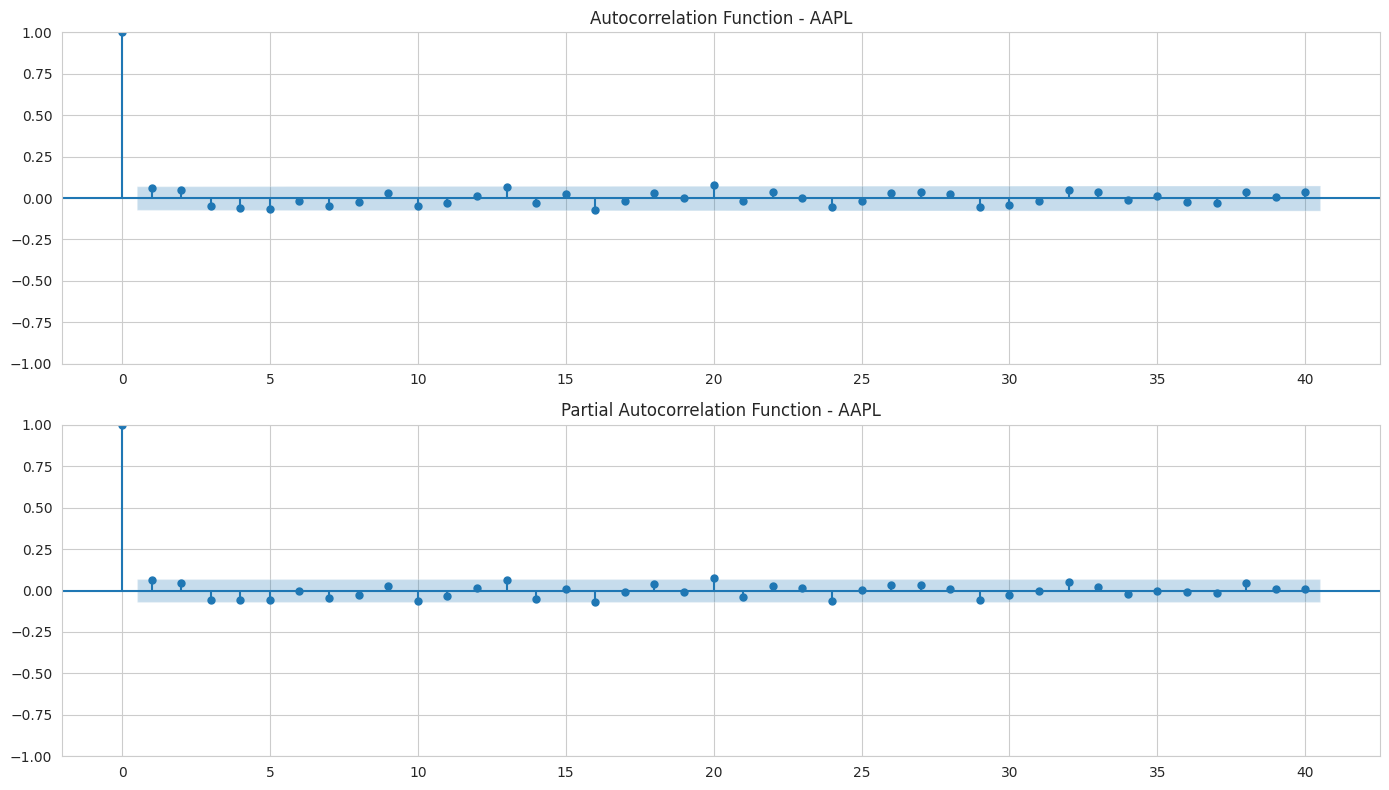

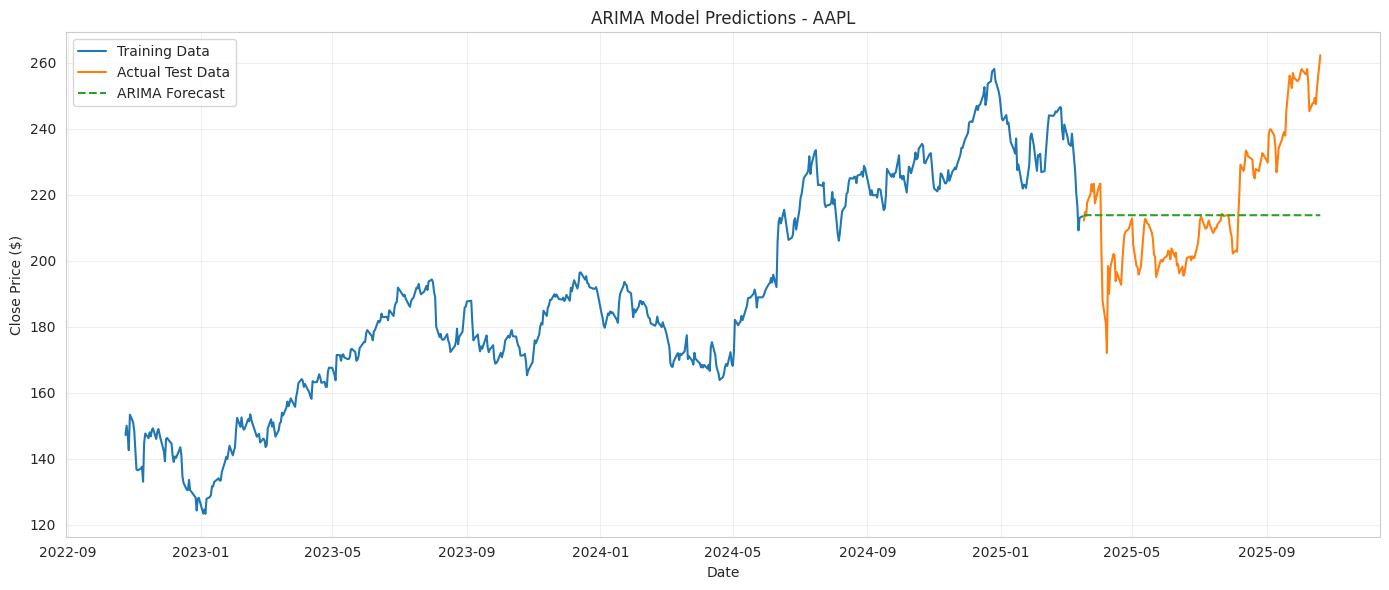

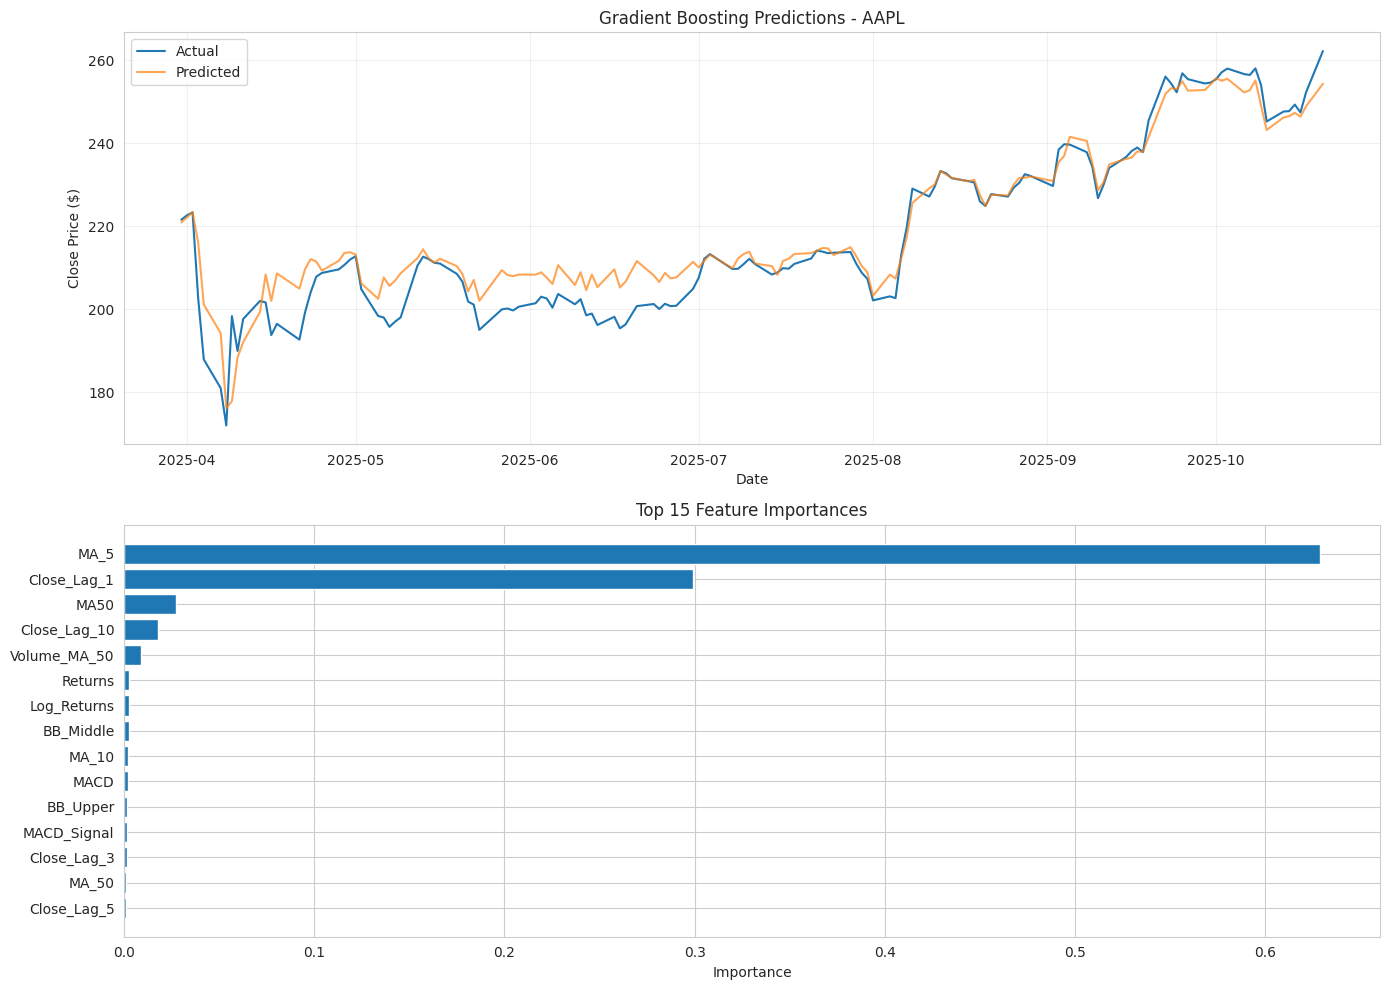

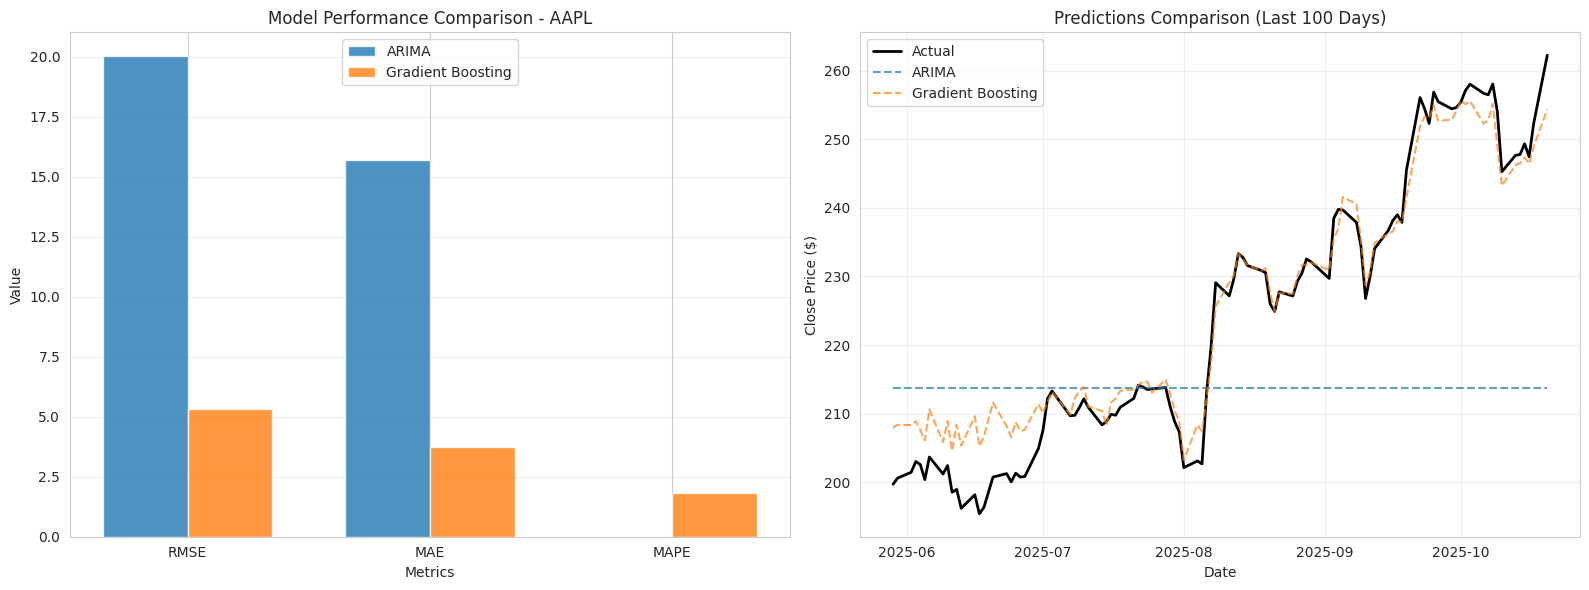

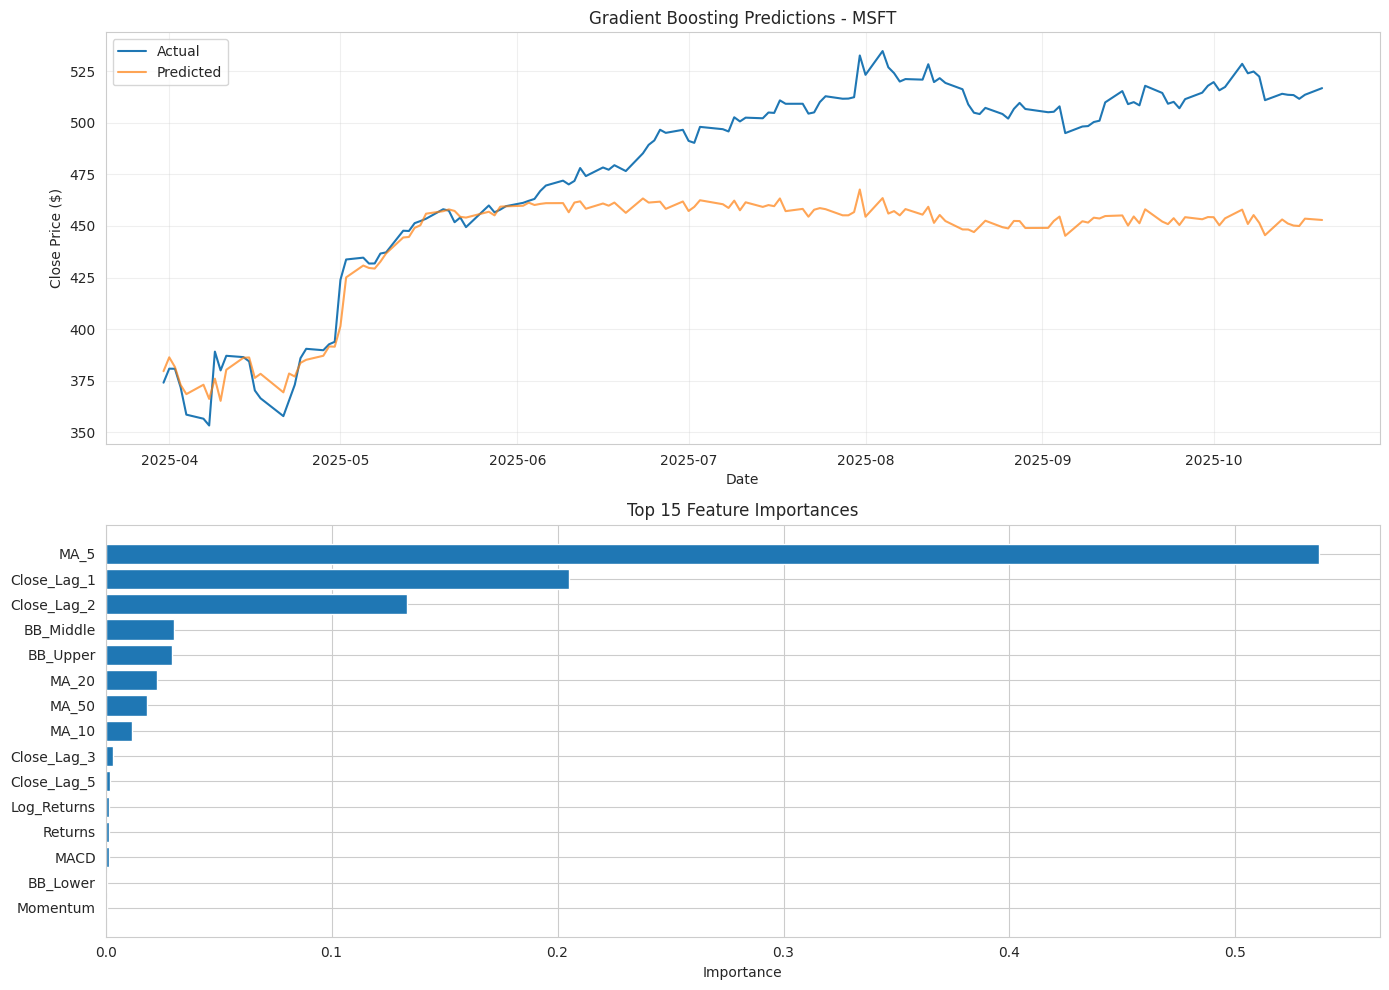

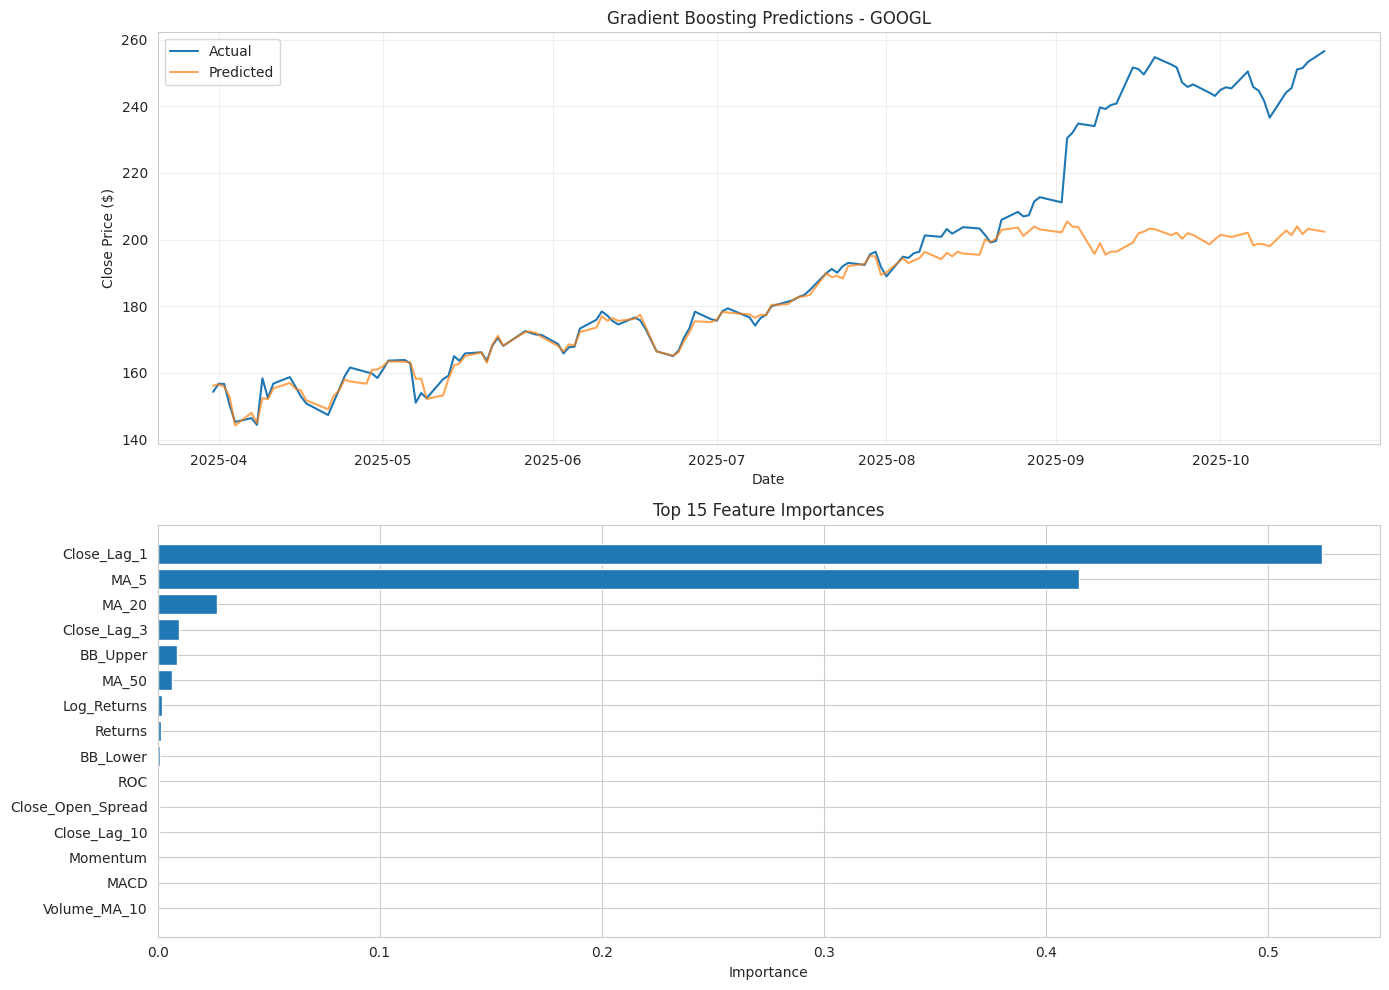

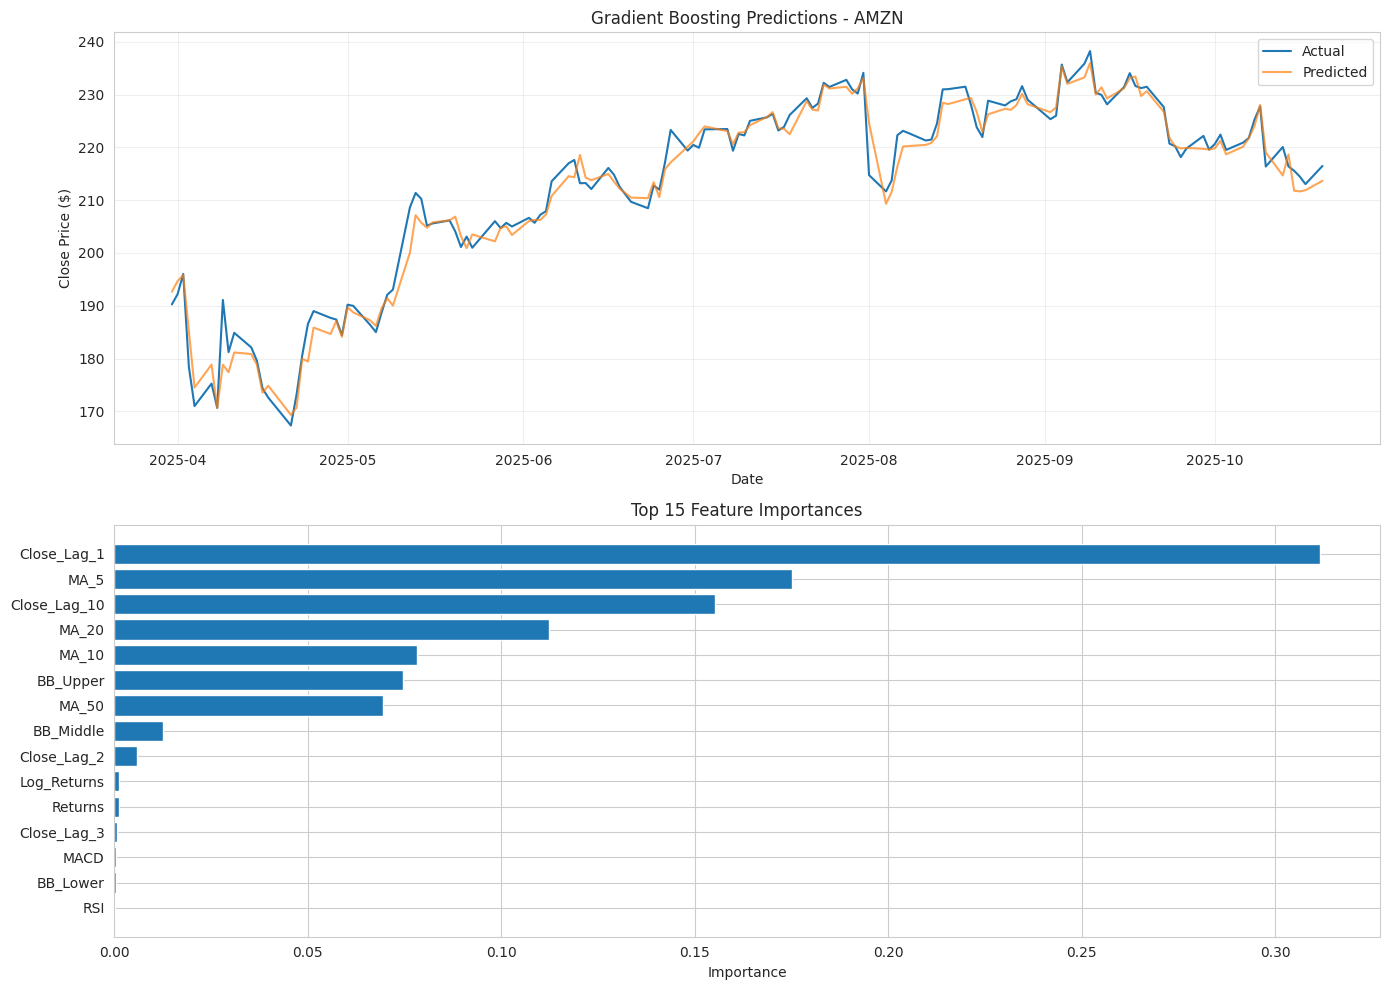

In [9]:
"""
Stock Market Prediction Pipeline
A comprehensive data science solution for hedge fund trading analysis
"""

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from pandas_schema import Column, Schema
from pandas_schema.validation import InRangeValidation, IsDistinctValidation
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

class StockDataPipeline:

    def __init__(self, tickers, start_date, end_date):

        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = {}
        self.cleaned_data = {}
        self.features_data = {}
        self.models = {}
        self.results = {}

    def fetch_data(self):
        print("=" * 80)
        print("TASK 1: DATA ACQUISITION")
        print("=" * 80)

        for ticker in self.tickers:
            try:
                print(f"\nFetching data for {ticker}...")
                stock = yf.Ticker(ticker)
                df = stock.history(start=self.start_date, end=self.end_date)

                if not df.empty:
                    self.data[ticker] = df
                    print(f" Successfully fetched {len(df)} records for {ticker}")
                    print(f"  Date range: {df.index[0].date()} to {df.index[-1].date()}")
                else:
                    print(f" No data available for {ticker}")
            except Exception as e:
                print(f" Error fetching {ticker}: {str(e)}")

        return self.data

    def validate_and_clean_data(self):


        print("TASK 2: DATA VALIDATION & CLEANING")
        print("=" * 80)

        for ticker, df in self.data.items():
            print(f"\n--- Cleaning {ticker} ---")

            # Create a copy
            cleaned_df = df.copy()

            # Check for missing values
            missing = cleaned_df.isnull().sum()
            print(f"Missing values:\n{missing[missing > 0]}")

            # Forward fill missing values (common for stock data)
            cleaned_df.fillna(method='ffill', inplace=True)
            cleaned_df.fillna(method='bfill', inplace=True)

            # Remove duplicates
            initial_len = len(cleaned_df)
            cleaned_df = cleaned_df[~cleaned_df.index.duplicated(keep='first')]
            print(f"Duplicates removed: {initial_len - len(cleaned_df)}")

            # Validate price ranges (prices should be positive)
            for col in ['Open', 'High', 'Low', 'Close']:
                if col in cleaned_df.columns:
                    negative_prices = (cleaned_df[col] <= 0).sum()
                    if negative_prices > 0:
                        print(f" Warning: {negative_prices} negative/zero values in {col}")
                        cleaned_df = cleaned_df[cleaned_df[col] > 0]

            # Validate High >= Low
            invalid_ranges = (cleaned_df['High'] < cleaned_df['Low']).sum()
            if invalid_ranges > 0:
                print(f" Warning: {invalid_ranges} records where High < Low")
                cleaned_df = cleaned_df[cleaned_df['High'] >= cleaned_df['Low']]

            # Sort by date
            cleaned_df = cleaned_df.sort_index()

            # Store cleaned data
            self.cleaned_data[ticker] = cleaned_df
            print(f" Cleaned dataset: {len(cleaned_df)} valid records")

        return self.cleaned_data

    def exploratory_data_analysis(self, ticker):

        print(f"TASK 3: EXPLORATORY DATA ANALYSIS - {ticker}")
        print("=" * 80)

        df = self.cleaned_data[ticker]

        # Basic statistics
        print(df[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

        # Create visualization figure
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        fig.suptitle(f'Exploratory Data Analysis - {ticker}', fontsize=16, fontweight='bold')

        axes[0, 0].plot(df.index, df['Close'], label='Close Price', linewidth=1.5)
        axes[0, 0].set_title('Historical Close Price')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Price ($)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].bar(df.index, df['Volume'], alpha=0.7, color='orange')
        axes[0, 1].set_title('Trading Volume')
        axes[0, 1].set_xlabel('Date')
        axes[0, 1].set_ylabel('Volume')
        axes[0, 1].grid(True, alpha=0.3)


        returns = df['Close'].pct_change().dropna()
        axes[1, 0].hist(returns, bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[1, 0].set_title('Distribution of Daily Returns')
        axes[1, 0].set_xlabel('Return (%)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].axvline(returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.4f}')
        axes[1, 0].legend()

        df['MA20'] = df['Close'].rolling(window=20).mean()
        df['MA50'] = df['Close'].rolling(window=50).mean()
        axes[1, 1].plot(df.index, df['Close'], label='Close', linewidth=1, alpha=0.7)
        axes[1, 1].plot(df.index, df['MA20'], label='20-Day MA', linewidth=1.5)
        axes[1, 1].plot(df.index, df['MA50'], label='50-Day MA', linewidth=1.5)
        axes[1, 1].set_title('Moving Averages')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Price ($)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        volatility = df['Close'].pct_change().rolling(window=30).std()
        axes[2, 0].plot(df.index, volatility, color='red', linewidth=1.5)
        axes[2, 0].set_title('30-Day Rolling Volatility')
        axes[2, 0].set_xlabel('Date')
        axes[2, 0].set_ylabel('Volatility')
        axes[2, 0].grid(True, alpha=0.3)

        axes[2, 1].scatter(df['Volume'], df['Close'], alpha=0.5)
        axes[2, 1].set_title('Price vs Volume')
        axes[2, 1].set_xlabel('Volume')
        axes[2, 1].set_ylabel('Close Price ($)')
        axes[2, 1].grid(True, alpha=0.3)

        corr = df['Volume'].corr(df['Close'])
        axes[2, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}',
                       transform=axes[2, 1].transAxes,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.savefig(f'{ticker}_eda.png', dpi=300, bbox_inches='tight')
        print(f"\n EDA plots saved as '{ticker}_eda.png'")

        print("\n--- Stationarity Test (Augmented Dickey-Fuller) ---")
        result = adfuller(df['Close'].dropna())
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        print(f"Stationary: {'Yes' if result[1] < 0.05 else 'No'}")

        return df

    def feature_engineering(self, ticker):
        """
        Create features for machine learning models
        """

        print(f"TASK 4: FEATURE ENGINEERING - {ticker}")
        print("=" * 80)

        df = self.cleaned_data[ticker].copy()

        for lag in [1, 2, 3, 5, 10]:
            df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
            df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)


        df['Returns'] = df['Close'].pct_change()
        df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))


        for window in [5, 10, 20, 50]:
            df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
            df[f'STD_{window}'] = df['Close'].rolling(window=window).std()
            df[f'Volume_MA_{window}'] = df['Volume'].rolling(window=window).mean()


        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=20).std()
        df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=20).std()

        df['High_Low_Spread'] = df['High'] - df['Low']
        df['Close_Open_Spread'] = df['Close'] - df['Open']

        df['Momentum'] = df['Close'] - df['Close'].shift(10)
        df['ROC'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100


        df_features = df.dropna()

        self.features_data[ticker] = df_features

        print(f"\n Created {len(df_features.columns)} features")
        print(f" Feature dataset shape: {df_features.shape}")
        print(f"\nFeature categories:")
        print(f"  - Lagged features: 10")
        print(f"  - Rolling statistics: 16")
        print(f"  - Technical indicators: 7")
        print(f"  - Price patterns: 2")
        print(f"  - Momentum indicators: 2")

        return df_features

    def build_arima_model(self, ticker, order=(5, 1, 0)):
        """
        Build and evaluate ARIMA model
        """

        print(f"TASK 5A: ARIMA MODELING - {ticker}")
        print("=" * 80)

        df = self.cleaned_data[ticker]['Close']

        train_size = int(len(df) * 0.8)
        train, test = df[:train_size], df[train_size:]

        print(f"\nTraining set: {len(train)} observations")
        print(f"Test set: {len(test)} observations")

        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        plot_acf(df.diff().dropna(), lags=40, ax=axes[0])
        axes[0].set_title(f'Autocorrelation Function - {ticker}')
        plot_pacf(df.diff().dropna(), lags=40, ax=axes[1])
        axes[1].set_title(f'Partial Autocorrelation Function - {ticker}')
        plt.tight_layout()
        plt.savefig(f'{ticker}_acf_pacf.png', dpi=300)
        print(f" ACF/PACF plots saved as '{ticker}_acf_pacf.png'")

        print(f"\nFitting ARIMA{order} model...")
        model = ARIMA(train, order=order)
        fitted_model = model.fit()

        print("\n--- Model Summary ---")
        print(fitted_model.summary())

        forecast = fitted_model.forecast(steps=len(test))

        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)
        mape = np.mean(np.abs((test - forecast) / test)) * 100

        print(f"\n--- Model Performance ---")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAE: ${mae:.2f}")
        print(f"MAPE: {mape:.2f}%")

        plt.figure(figsize=(14, 6))
        plt.plot(train.index, train, label='Training Data', linewidth=1.5)
        plt.plot(test.index, test, label='Actual Test Data', linewidth=1.5)
        plt.plot(test.index, forecast, label='ARIMA Forecast', linewidth=1.5, linestyle='--')
        plt.title(f'ARIMA Model Predictions - {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Close Price ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{ticker}_arima_predictions.png', dpi=300)
        print(f" Prediction plot saved as '{ticker}_arima_predictions.png'")

        self.models[f'{ticker}_ARIMA'] = fitted_model
        self.results[f'{ticker}_ARIMA'] = {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'predictions': forecast,
            'actual': test
        }

        return fitted_model, forecast

    def build_gradient_boosting_model(self, ticker):
        """
        Build and evaluate Gradient Boosting model
        """

        print(f"TASK 5B: GRADIENT BOOSTING MODELING - {ticker}")
        print("=" * 80)

        df = self.features_data[ticker].copy()

        target_col = 'Close'
        exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
        feature_cols = [col for col in df.columns if col not in exclude_cols]

        X = df[feature_cols]
        y = df[target_col]

        split_idx = int(len(df) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        print(f"\nTraining set: {len(X_train)} observations")
        print(f"Test set: {len(X_test)} observations")
        print(f"Number of features: {len(feature_cols)}")

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        print("\nPerforming Grid Search for hyperparameter tuning...")

        gbr = GradientBoostingRegressor(random_state=42)
        grid_search = GridSearchCV(gbr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)

        print(f"\n Best parameters: {grid_search.best_params_}")

        best_model = grid_search.best_estimator_

        y_pred_train = best_model.predict(X_train_scaled)
        y_pred_test = best_model.predict(X_test_scaled)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

        print(f"\n--- Model Performance ---")
        print(f"Training RMSE: ${train_rmse:.2f}")
        print(f"Test RMSE: ${test_rmse:.2f}")
        print(f"Test MAE: ${test_mae:.2f}")
        print(f"Test MAPE: {test_mape:.2f}%")

        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print(f"\n--- Top 10 Most Important Features ---")
        print(feature_importance.head(10).to_string(index=False))

        fig, axes = plt.subplots(2, 1, figsize=(14, 10))

        axes[0].plot(y_test.index, y_test.values, label='Actual', linewidth=1.5)
        axes[0].plot(y_test.index, y_pred_test, label='Predicted', linewidth=1.5, alpha=0.7)
        axes[0].set_title(f'Gradient Boosting Predictions - {ticker}')
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Close Price ($)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        top_features = feature_importance.head(15)
        axes[1].barh(top_features['feature'], top_features['importance'])
        axes[1].set_xlabel('Importance')
        axes[1].set_title('Top 15 Feature Importances')
        axes[1].invert_yaxis()

        plt.tight_layout()
        plt.savefig(f'{ticker}_gb_predictions.png', dpi=300)
        print(f"\n Prediction plot saved as '{ticker}_gb_predictions.png'")

        self.models[f'{ticker}_GB'] = best_model
        self.results[f'{ticker}_GB'] = {
            'RMSE': test_rmse,
            'MAE': test_mae,
            'MAPE': test_mape,
            'predictions': y_pred_test,
            'actual': y_test.values,
            'feature_importance': feature_importance
        }

        return best_model, y_pred_test

    def compare_models(self, ticker):
        """
        Compare ARIMA and Gradient Boosting models
        """

        print(f"TASK 6: MODEL COMPARISON - {ticker}")
        print("=" * 80)

        arima_results = self.results.get(f'{ticker}_ARIMA')
        gb_results = self.results.get(f'{ticker}_GB')

        if not arima_results or not gb_results:
            print(" Both models need to be trained before comparison")
            return

        comparison = pd.DataFrame({
            'Metric': ['RMSE ($)', 'MAE ($)', 'MAPE (%)'],
            'ARIMA': [arima_results['RMSE'], arima_results['MAE'], arima_results['MAPE']],
            'Gradient Boosting': [gb_results['RMSE'], gb_results['MAE'], gb_results['MAPE']]
        })

        comparison['Winner'] = comparison.apply(
            lambda row: 'ARIMA' if row['ARIMA'] < row['Gradient Boosting'] else 'GB',
            axis=1
        )

        print("\n--- Performance Comparison ---")
        print(comparison.to_string(index=False))

        arima_wins = (comparison['Winner'] == 'ARIMA').sum()
        gb_wins = (comparison['Winner'] == 'GB').sum()

        print(f"\n--- Overall Winner ---")
        if gb_wins > arima_wins:
            print(f" Gradient Boosting (wins {gb_wins}/3 metrics)")
        elif arima_wins > gb_wins:
            print(f" ARIMA (wins {arima_wins}/3 metrics)")
        else:
            print(" Tie")


        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        metrics = ['RMSE', 'MAE', 'MAPE']
        arima_values = [arima_results['RMSE'], arima_results['MAE'], arima_results['MAPE']]
        gb_values = [gb_results['RMSE'], gb_results['MAE'], gb_results['MAPE']]

        x = np.arange(len(metrics))
        width = 0.35

        axes[0].bar(x - width/2, arima_values, width, label='ARIMA', alpha=0.8)
        axes[0].bar(x + width/2, gb_values, width, label='Gradient Boosting', alpha=0.8)
        axes[0].set_xlabel('Metrics')
        axes[0].set_ylabel('Value')
        axes[0].set_title(f'Model Performance Comparison - {ticker}')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(metrics)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')

        n_days = min(100, len(arima_results['actual']))
        dates = arima_results['actual'].index[-n_days:]
        actual = arima_results['actual'].values[-n_days:]
        arima_pred = arima_results['predictions'].values[-n_days:]

        gb_actual = gb_results['actual'][-n_days:]
        gb_pred = gb_results['predictions'][-n_days:]

        axes[1].plot(dates, actual, label='Actual', linewidth=2, color='black')
        axes[1].plot(dates, arima_pred, label='ARIMA', linewidth=1.5, alpha=0.7, linestyle='--')
        axes[1].plot(dates, gb_pred, label='Gradient Boosting', linewidth=1.5, alpha=0.7, linestyle='--')
        axes[1].set_title(f'Predictions Comparison (Last {n_days} Days)')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Close Price ($)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{ticker}_model_comparison.png', dpi=300)
        print(f"\n Comparison plot saved as '{ticker}_model_comparison.png'")

        return comparison

    def generate_trading_recommendations(self, ticker):
        """
        Generate trading strategy recommendations based on model insights
        """

        print(f"TASK 7: TRADING RECOMMENDATIONS - {ticker}")
        print("=" * 80)

        gb_results = self.results.get(f'{ticker}_GB')

        if not gb_results:
            print(" Gradient Boosting model needed for recommendations")
            return

        feature_imp = gb_results['feature_importance'].head(10)

        print("\n--- Key Insights ---")
        print(f"\n1. Most Predictive Features:")
        for idx, row in feature_imp.head(5).iterrows():
            print(f"   • {row['feature']}: {row['importance']:.4f}")

        mape = gb_results['MAPE']
        print(f"\n2. Model Accuracy:")
        if mape < 2:
            print(f"   • Excellent accuracy (MAPE: {mape:.2f}%)")
            print("   • High confidence for short-term predictions")
        elif mape < 5:
            print(f"   • Good accuracy (MAPE: {mape:.2f}%)")
            print("   • Reliable for tactical trading decisions")
        else:
            print(f"   • Moderate accuracy (MAPE: {mape:.2f}%)")
            print("   • Use with additional technical analysis")

        print("\n--- Trading Strategy Recommendations ---")
        print("\n1. Model Deployment:")
        print("   • Use Gradient Boosting for daily price predictions")
        print("   • Retrain model weekly with new data")
        print("   • Set stop-loss at 2x model RMSE")

        print("\n2. Risk Management:")
        print(f"   • Expected prediction error: ±${gb_results['RMSE']:.2f}")
        print("   • Position sizing: Account for model uncertainty")
        print("   • Diversify across multiple stock predictions")

        print("\n3. Signal Generation:")
        print("   • BUY: When predicted price > current price + RMSE")
        print("   • SELL: When predicted price < current price - RMSE")
        print("   • HOLD: Within RMSE range")

        print("\n4. Feature-Based Insights:")
        if any('Lag' in feat for feat in feature_imp['feature'].head(3).values):
            print("   • Recent price momentum is highly predictive")
            print("   • Consider momentum-based strategies")

        if any('MA' in feat for feat in feature_imp['feature'].head(3).values):
            print("   • Moving averages are key indicators")
            print("   • Trend-following strategies recommended")

        if any('Volume' in feat for feat in feature_imp['feature'].head(3).values):
            print("   • Volume patterns are significant")
            print("   • Monitor volume breakouts")

        print("\n5. Limitations & Cautions:")
        print("   • Models perform best in stable market conditions")
        print("   • Black swan events not captured in historical data")
        print("   • Always combine with fundamental analysis")
        print("   • Monitor model drift and retrain regularly")

def main():
    """
    Main execution function
    """
    print("\n" + "=" * 80)
    print("STOCK MARKET PREDICTION PIPELINE")
    print("Hedge Fund Data Science Internship Project")
    print("=" * 80)

    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'V', 'NVDA']
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=3*365)).strftime('%Y-%m-%d')  # 3 years of data

    print(f"\nAnalyzing {len(tickers)} stocks: {', '.join(tickers)}")
    print(f"Date range: {start_date} to {end_date}")

    pipeline = StockDataPipeline(tickers, start_date, end_date)

    try:

        pipeline.fetch_data()
        pipeline.validate_and_clean_data()
        primary_ticker = 'AAPL'
        pipeline.exploratory_data_analysis(primary_ticker)
        pipeline.feature_engineering(primary_ticker)

        pipeline.build_arima_model(primary_ticker, order=(5, 1, 0))
        pipeline.build_gradient_boosting_model(primary_ticker)
        pipeline.compare_models(primary_ticker)

        pipeline.generate_trading_recommendations(primary_ticker)


        print("PIPELINE EXECUTION COMPLETE")
        print("=" * 80)
        print("\nGenerated outputs:")
        print(f"  • {primary_ticker}_eda.png - Exploratory data analysis visualizations")
        print(f"  • {primary_ticker}_acf_pacf.png - ACF/PACF plots for ARIMA")
        print(f"  • {primary_ticker}_arima_predictions.png - ARIMA model predictions")
        print(f"  • {primary_ticker}_gb_predictions.png - Gradient Boosting predictions")
        print(f"  • {primary_ticker}_model_comparison.png - Model performance comparison")

        print("\n Analysis complete! Review the visualizations and recommendations.")
        print(" Models are ready for deployment and backtesting.")


        print("Quick Analysis of Other Stocks")
        print("=" * 80)

        for ticker in tickers[1:4]:
            if ticker in pipeline.cleaned_data:
                print(f"\n--- {ticker} ---")
                pipeline.feature_engineering(ticker)
                _, _ = pipeline.build_gradient_boosting_model(ticker)

        print("SUMMARY: ALL STOCKS PERFORMANCE")
        print("=" * 80)

        summary_data = []
        for key, result in pipeline.results.items():
            if 'GB' in key:
                ticker_name = key.replace('_GB', '')
                summary_data.append({
                    'Ticker': ticker_name,
                    'RMSE ($)': f"{result['RMSE']:.2f}",
                    'MAE ($)': f"{result['MAE']:.2f}",
                    'MAPE (%)': f"{result['MAPE']:.2f}"
                })

        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            print("\n" + summary_df.to_string(index=False))

        return pipeline

    except Exception as e:
        print(f"\n Error during execution: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":

    pipeline = main()

    if pipeline and len(pipeline.results) > 0:

        print("PORTFOLIO-LEVEL RECOMMENDATIONS")
        print("=" * 80)

        print("\n1. Model Reliability Ranking:")
        gb_models = {k: v for k, v in pipeline.results.items() if 'GB' in k}
        sorted_models = sorted(gb_models.items(), key=lambda x: x[1]['MAPE'])

        for i, (model_name, results) in enumerate(sorted_models[:5], 1):
            ticker = model_name.replace('_GB', '')
            print(f"   {i}. {ticker}: MAPE = {results['MAPE']:.2f}%")


        print("Thank you for using the Stock Prediction Pipeline!")
        print("=" * 80)